# Load dataset

In [96]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
data = pd.read_csv('apple_stocks.csv') 

In [69]:
data.head()

,Date,Open,High,Low,Close,Volume
0,7-Jul-17,142.90,144.75,142.90,144.18,19201712
1,6-Jul-17,143.02,143.50,142.41,142.73,24128782
2,5-Jul-17,143.69,144.79,142.72,144.09,21569557
3,3-Jul-17,144.88,145.30,143.10,143.50,14277848
4,30-Jun-17,144.45,144.96,143.78,144.02,23024107


In [70]:
len(data)

129

# Data Preprocessing

1. Prepare the data:
2. Convert ‘Date’ to datetime formatt
3. Handle missing valuese
4. Engineer features like daily returns.
5. Optionally, scale numerical features.
6. Define a target variable (e.g., price increase or decrease).

In [72]:
# data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


In [73]:
data.head()

,Date,Open,High,Low,Close,Volume
0,2017-07-07,142.90,144.75,142.90,144.18,19201712
1,2017-07-06,143.02,143.50,142.41,142.73,24128782
2,2017-07-05,143.69,144.79,142.72,144.09,21569557
3,2017-07-03,144.88,145.30,143.10,143.50,14277848
4,2017-06-30,144.45,144.96,143.78,144.02,23024107


In [74]:
# data.sort_values(by='Date', inplace=True)
# data.head()

In [75]:
data.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

No missing values

In [76]:
# Engineer daily returns feature
data['Daily_Return'] = data['Close'].pct_change()

# Drop the first row which will have NaN daily return
data.dropna(subset=['Daily_Return'], inplace=True)

# Verify the daily returns calculation
# print("\nDataFrame with Daily Returns:")
data.head()

,Date,Open,High,Low,Close,Volume,Daily_Return
1,2017-07-06,143.02,143.50,142.41,142.73,24128782,-0.010057
2,2017-07-05,143.69,144.79,142.72,144.09,21569557,0.009528
3,2017-07-03,144.88,145.30,143.10,143.50,14277848,-0.004095
4,2017-06-30,144.45,144.96,143.78,144.02,23024107,0.003624
5,2017-06-29,144.71,145.13,142.28,143.68,31499368,-0.002361


In [77]:
# Define the target variable (1 for price increase, 0 for price decrease)
data['Target'] = data['Close'].shift(-1) > data['Close']
data['Target'] = data['Target'].astype(int)  # Convert boolean to int
data.dropna(subset=['Target'], inplace=True)

# Display the processed DataFrame
print("Processed DataFrame:")
data.head()

Processed DataFrame:


,Date,Open,High,Low,Close,Volume,Daily_Return,Target
1,2017-07-06,143.02,143.50,142.41,142.73,24128782,-0.010057,1
2,2017-07-05,143.69,144.79,142.72,144.09,21569557,0.009528,0
3,2017-07-03,144.88,145.30,143.10,143.50,14277848,-0.004095,1
4,2017-06-30,144.45,144.96,143.78,144.02,23024107,0.003624,0
5,2017-06-29,144.71,145.13,142.28,143.68,31499368,-0.002361,1


In [78]:
data.drop(columns="Date", inplace=True)

In [79]:
scaler = StandardScaler()
data[['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return']] = scaler.fit_transform(
    data[['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return']]
)


In [80]:
data.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Daily_Return    0
Target          0
dtype: int64

In [81]:
data.head()

,Open,High,Low,Close,Volume,Daily_Return,Target
1,0.292339,0.258816,0.316809,0.258692,-0.249597,-0.797821,1
2,0.353223,0.376054,0.345780,0.384906,-0.462862,1.056741,0
3,0.461361,0.422404,0.381293,0.330152,-1.070493,-0.233252,1
4,0.422286,0.391504,0.444843,0.378410,-0.341652,0.497610,0
5,0.445913,0.406954,0.304659,0.346857,0.364607,-0.069068,1


# EDA

In [82]:
data.describe()

,Open,High,Low,Close,Volume,Daily_Return,Target
count,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,128.000000,128.000000
mean,7.702172e-16,-2.310652e-15,1.769418e-16,4.128642e-16,6.938894e-18,0.000000,0.453125
std,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00,1.003929,0.499754
min,-2.181202e+00,-2.210454e+00,-2.267250e+00,-2.220114e+00,-1.073118e+00,-5.287973,0.000000
25%,-3.789796e-01,-4.066695e-01,-3.724294e-01,-3.967389e-01,-5.511809e-01,-0.409016,0.000000
50%,2.005577e-01,2.006509e-01,1.925120e-01,1.955853e-01,-2.899925e-01,0.099638,0.000000
75%,5.401925e-01,5.900812e-01,5.537195e-01,5.596107e-01,2.946090e-01,0.412337,1.000000
max,1.472768e+00,1.453917e+00,1.498092e+00,1.499488e+00,7.071623e+00,3.974417,1.000000


In [16]:
# # Assuming 'data' is your DataFrame and 'Target' is the column to predict
# # Make sure 'Target' is included in 'data' for the pairplot
# pairplot_data = data.copy()

# # Create the pairplot
# sns.pairplot(pairplot_data, hue='Target', palette='viridis', diag_kind='kde')

# # Show the plot
# plt.suptitle('Pairplot of Features', y=1.02)  # Adjust title position
# plt.show()


# Split data and Scale

In [83]:
X = data.drop(columns = ['Target', 
                         # 'Open',
                         # 'High',
                         # 'Low',
                         # 'Volume',
                         # 'Daily_Return'
                        ])
y = data['Target']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [85]:
# # Initialize the scaler
# scaler = StandardScaler()

# # Fit the scaler on the training data and transform both training and test data
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [86]:
len(y_train), len(y_test)

(102, 26)

# Define the Random Forest Classifier

In [98]:
# Define the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Grid Search

In [99]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


# Training

In [100]:
# Train the final model with the best hyperparameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)

In [101]:
cross_val_scores = cross_val_score(best_rf, X_train, y_train, cv=5)
print(cross_val_scores)

[0.66666667 0.71428571 0.7        0.75       0.6       ]


# Classification Report

In [90]:
# Predictions on the test set
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]  # Probabilities for the ROC curve

# Metrics and Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.71      0.61        14
           1       0.43      0.25      0.32        12

    accuracy                           0.50        26
   macro avg       0.48      0.48      0.46        26
weighted avg       0.48      0.50      0.47        26



In [91]:
# Predictions on the test set
y_pred_t = best_rf.predict(X_train)

# Metrics and Report
print("Classification Report:")
print(classification_report(y_train, y_pred_t))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        56
           1       0.91      0.89      0.90        46

    accuracy                           0.91       102
   macro avg       0.91      0.91      0.91       102
weighted avg       0.91      0.91      0.91       102



# ROC Curve

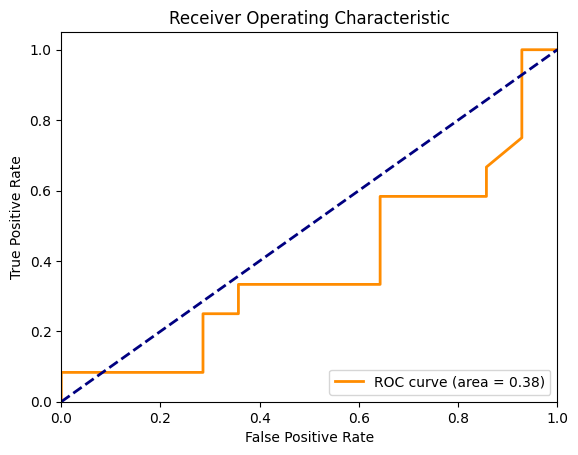

In [92]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

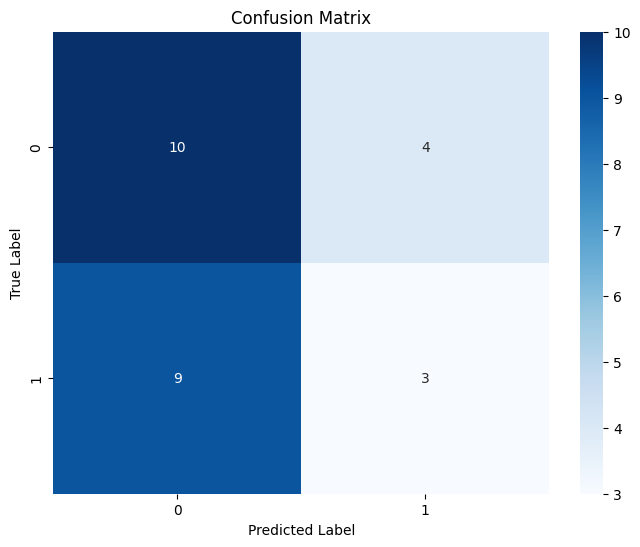

In [93]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

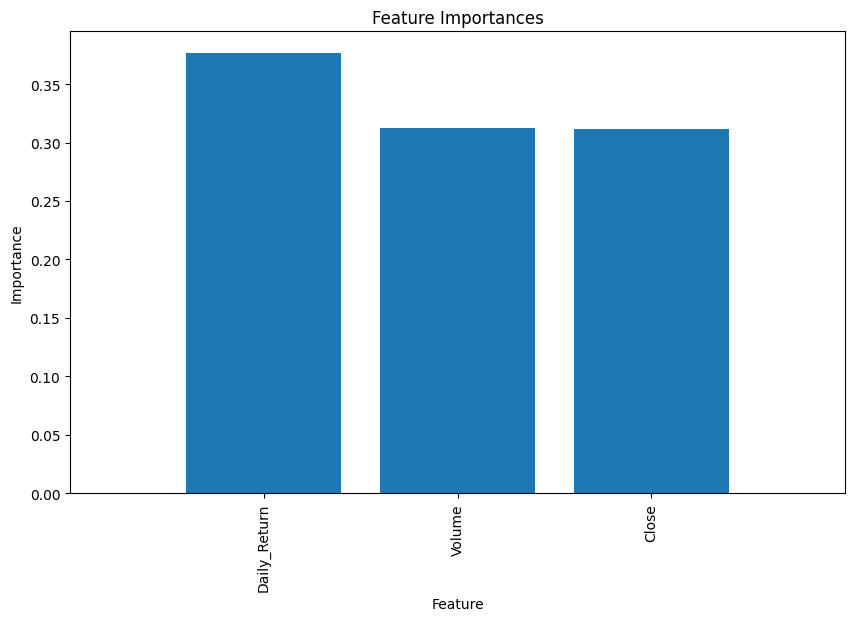

In [94]:
# Feature Importances
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()